# Text Classification of Sentences
## Identifying Police Violence

In [2]:
import pandas
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report



ModuleNotFoundError: No module named 'wordcloud'

In [3]:

hrv_password = ""

In [ ]:
import pymysql.cursors

db = pymysql.connect(host = 'cse.unl.edu',
                     user = 'humanrights',
                     password = hrv_password,
                     database = 'humanrights')

cursor = db.cursor()

cursor.execute()

In [4]:
df = pandas.read_sql("""SELECT sentence, hand_label FROM PoliceSentences WHERE hand_label IS NOT NULL""",
                    db)

## Preprocessing and Feature Extraction

In [ ]:
sentences = df['sentence']
y = df['hand_label']

In [10]:

lemmatizer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
def process_word(word):

    word = lemmatizer.lemmatize(word)
    
    return word

# An extensive list of stop words obtained from a union of several lists.
stop_words = eval(open('stop_words.txt').read())

# Additional stop words for the context of Indian HRV
stop_words.extend(["india", "delhi", "singh"])

stop_words = [process_word(word) for word in stop_words]

def process_sentence(sentence):        
    sentence = (process_word(w) for w in analyzer(sentence) if len(w) > 3)
    return (w for w in sentence if (w not in stop_words) and (w[0] not in "0123456789"))

binary_vectorizer = CountVectorizer(strip_accents = 'ascii', analyzer = process_sentence, binary = True)
count_vectorizer = CountVectorizer(strip_accents = 'ascii', analyzer = process_sentence)
tfidf_vectorizer = TfidfVectorizer(strip_accents='ascii', analyzer = process_sentence)


X_binary = binary_vectorizer.fit_transform(sentences)
X_tfidf = tfidf_vectorizer.fit_transform(sentences)
X_count = count_vectorizer.fit_transform(sentences)


## Data Visualization - Word Clouds

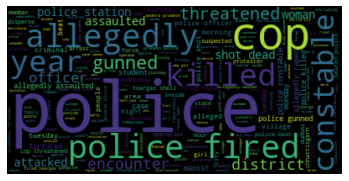

In [24]:
 # Start with one review:
text = " ".join(" ".join(process_sentence(sentence)) for sentence in df[df['hand_label'] == 1]['sentence'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

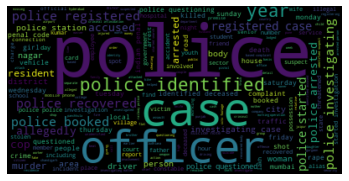

In [25]:
 # Start with one review:
text = " ".join(" ".join(process_sentence(sentence)) for sentence in df[df['hand_label'] == 0]['sentence'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_binary, y, test_size = 0.2)
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_tfidf, y, test_size = 0.2)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_count, y, test_size = 0.2)

## Bernoulli Naive Bayes

In [30]:
%%time

param_grid = {'alpha':[0.0001, 0.001, 0.1, 1.0, 1.5, 2.0]}

clf_bernoulli_cv = GridSearchCV(BernoulliNB(), param_grid, cv=5, verbose=1, n_jobs=-1)

clf_bernoulli_cv = clf_bernoulli_cv.fit(Xb_train, yb_train)

print("Best Parameters:", clf_bernoulli_cv.best_params_)
print("Best Score:", clf_bernoulli_cv.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Parameters: {'alpha': 0.1}
Best Score: 0.8701298701298701
Wall time: 3.72 s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.6s finished


In [31]:
%%time
bnb = clf_bernoulli_cv.best_estimator_

bnb.fit(Xb_train, yb_train)


Wall time: 2 ms


BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)

In [34]:


yb_pred = bnb.predict(Xb_test)
print("Test - Results from BernoulliNB with Binary CountVectorizer")
print()
print("Test - Confusion Matrix")
print(confusion_matrix(yb_test, yb_pred))
print()
print("Test - Classification Report")
print(classification_report(yb_test, yb_pred))

Test - Results from BernoulliNB with Binary CountVectorizer

Test - Confusion Matrix
[[199  19]
 [ 22 126]]

Test - Classification Report
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       218
           1       0.87      0.85      0.86       148

    accuracy                           0.89       366
   macro avg       0.88      0.88      0.88       366
weighted avg       0.89      0.89      0.89       366



## Multinomial Naive Bayes

In [36]:
%%time

features = Xc_train
target = yc_train

param_grid = {
    'alpha':[0.0001, 0.001, 0.1, 1.0, 1.5, 2.0]
}

clf_multinomial_cv = GridSearchCV(MultinomialNB(), param_grid, cv=5, verbose=1, n_jobs=-1)

clf_multinomial_cv = clf_multinomial_cv.fit(features, target)

print("Best parameters:",clf_multinomial_cv.best_params_)
print("Best Score:", clf_multinomial_cv.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'alpha': 2.0}
Best Score: 0.9022556390977443
Wall time: 81 ms


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


In [37]:
%%time

mnb = clf_multinomial_cv.best_estimator_
mnb.fit(Xc_train.toarray(), yc_train)

Wall time: 65 ms


MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

In [38]:

ym_pred = mnb.predict(Xc_test)
print("Test - Results from MultinomialNB with CountVectorizer")
print()
print("Test - Confusion Matrix")
print(confusion_matrix(yc_test, ym_pred))
print()
print("Test - Classification Report")
print(classification_report(yc_test, ym_pred))

Test - Results from MultinomialNB with CountVectorizer

Test - Confusion Matrix
[[193  29]
 [ 11 133]]

Test - Classification Report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       222
           1       0.82      0.92      0.87       144

    accuracy                           0.89       366
   macro avg       0.88      0.90      0.89       366
weighted avg       0.90      0.89      0.89       366



## Gaussian Naive Bayes

In [40]:
%%time

param_grid = {
    'priors':[None, [0.8, 0.2]],
    'var_smoothing':[1e-9, 1e-8, 1e-7]
}

clf_gaussian_cv = GridSearchCV(GaussianNB(), param_grid, cv=5, verbose=1, n_jobs=-1)

clf_gaussian_cv = clf_gaussian_cv.fit(Xc_train.toarray(), yc_train)

print("\nBest parameters:",clf_multinomial_cv.best_params_)
print("\nBest Score:", clf_multinomial_cv.best_score_)



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.3s finished



Best parameters: {'alpha': 2.0}

Best Score: 0.9022556390977443
Wall time: 2.7 s


In [41]:
%%time

gnb = clf_gaussian_cv.best_estimator_

gnb.fit(Xc_train.toarray(), yc_train)

Wall time: 139 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [43]:

yg_pred = gnb.predict(Xc_test.toarray())
print("Test - Results from GaussianNB with CountVectorizer")
print()
print("Test - Confusion Matrix")
print(confusion_matrix(yc_test, yg_pred))
print()
print("Test - Classification Report")
print(classification_report(yc_test, yg_pred))

Test - Results from GaussianNB with CountVectorizer

Test - Confusion Matrix
[[124  98]
 [ 32 112]]

Test - Classification Report
              precision    recall  f1-score   support

           0       0.79      0.56      0.66       222
           1       0.53      0.78      0.63       144

    accuracy                           0.64       366
   macro avg       0.66      0.67      0.64       366
weighted avg       0.69      0.64      0.65       366



In [45]:
%%time

param_grid = {
    'priors':[None, [0.8, 0.2]],
    'var_smoothing':[1e-9, 1e-8, 1e-7]
}

clf_gaussian_cv = GridSearchCV(GaussianNB(), param_grid, cv=5, verbose=1, n_jobs=-1)

clf_gaussian_cv = clf_gaussian_cv.fit(Xt_train.toarray(), yt_train)

print("\nBest parameters:",clf_multinomial_cv.best_params_)
print("\nBest Score:", clf_multinomial_cv.best_score_)



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.5s finished



Best parameters: {'alpha': 2.0}

Best Score: 0.9022556390977443
Wall time: 2.82 s


%%time

gnb = clf_gaussian_cv.best_estimator_

gnb.fit(Xt_train.toarray(), yt_train)

In [48]:

yg_pred = gnb.predict(Xt_test.toarray())
print("Test - Results from GaussianNB with TfidfVectorizer")
print()
print("Test - Confusion Matrix")
print(confusion_matrix(yt_test, yg_pred))
print()
print("Test - Classification Report")
print(classification_report(yt_test, yg_pred))

Test - Results from GaussianNB with TfidfVectorizer

Test - Confusion Matrix
[[160  53]
 [ 46 107]]

Test - Classification Report
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       213
           1       0.67      0.70      0.68       153

    accuracy                           0.73       366
   macro avg       0.72      0.73      0.72       366
weighted avg       0.73      0.73      0.73       366



## Model Evaluations with Receiver Operating Characteristic Curves (ROC)

In [65]:
bnb_proba = bnb.predict_proba(Xb_test)
bnb_scores = bnb_proba[:,1]
mnb_proba = mnb.predict_proba(Xc_test)
mnb_scores = mnb_proba[:,1]

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score
from scikitplot.metrics import plot_roc_curve


C:\Users\marcu\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


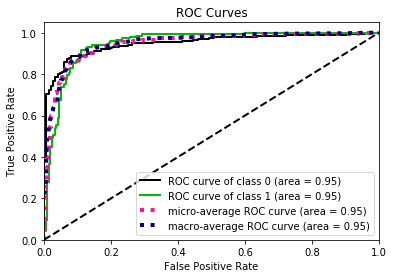

In [73]:
plot_roc_curve(yb_test, bnb_proba)

C:\Users\marcu\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


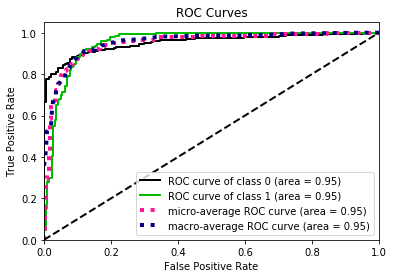

In [74]:
plot_roc_curve(yc_test, mnb_proba)

In [77]:
print("Bernoulli Naive Bayes: AUC =", roc_auc_score(yb_test, bnb_scores))
print("Multinomial Naive Bayes: AUC =", roc_auc_score(yc_test, mnb_scores))

Bernoulli Naive Bayes: AUC = 0.9491383585420283
Multinomial Naive Bayes: AUC = 0.9527027027027027


## One more classifier - Decision Trees

In [79]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(Xb_train, yb_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [84]:
dt_pred = dt.predict(Xb_test)
print("Test - Results from Decision Tree with Binary Vectorizer")
print()
print("Test - Confusion Matrix")
print(confusion_matrix(yb_test, dt_pred))
print()
print("Test - Classification Report")
print(classification_report(yb_test, dt_pred))

Test - Results from Decision Tree with Binary Vectorizer

Test - Confusion Matrix
[[208  10]
 [  9 139]]

Test - Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       218
           1       0.93      0.94      0.94       148

    accuracy                           0.95       366
   macro avg       0.95      0.95      0.95       366
weighted avg       0.95      0.95      0.95       366



In [87]:
dt_proba = dt.predict_proba(Xb_test)
dt_scores = dt_proba[:,1]

In [90]:
#plot_roc_curve(yb_test, dt_proba)